<a href="https://colab.research.google.com/github/mscholl96/mad-recime/blob/network_CVAE/network/CVAE/cvae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional variational autoencoder
Variational autoencoder for tabular data, oriented upon: https://lschmiddey.github.io/fastpages_/2021/03/14/tabular-data-variational-autoencoder.html 

Adopted with one hot encoding for tabular data
## Load Json Database of recipes

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [9]:
dataPath = '/content/drive/MyDrive/TP2/Datasets/Recipe1M/2022_02_11/ingredients_complete.pkl'
embeddingPath = '/content/drive/MyDrive/TP2/Datasets/Recipe1M/vocab.bin'
unitDictPath = '/content/drive/MyDrive/TP2/Datasets/Recipe1M/2022_02_11/ingredients_unitDict.pkl'
import sys
sys.path.append(dataPath)

In [10]:
dataPath = 'data/ingredients_complete_2k.pkl'
embeddingPath = 'data/vocab.bin'
unitDictPath = 'data/ingredients_unitDict.pkl'

In [11]:
import pickle
import pandas as pd

with open(dataPath, 'rb') as f:
    pklData = pickle.load(f)

print(pklData.keys())
print(len(pklData))

Index(['ingredients'], dtype='object')
2000


## Convert list of ingredients to pandas dataframe and one hot encode the dataframe.

In [12]:
!pip install word2vec

In [13]:
from src.ReciMePreprocessor import ReciMePreprocessor

preprocessor = ReciMePreprocessor(embeddingPath, unitDictPath)
#pklData = pklData[:2000]
#processedInput = preprocessor.preProcessInput(pklData['ingredients'])

## VAE
### Setup

In [14]:
# Import pytorch dependencies
import torch
from torch import optim
from torch.utils.data import DataLoader

# Import additional libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Import custom autoencoder
from src.ReciMeEncoder import ReciMeEncoder

# Import custom helper functions
from src.networkUtils import CustomLoss, DataBuilder

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### Setup Datasets + Hyperparameters

In [15]:
# One hot encoding without embedding and using sparse frame
train_data, test_data =  train_test_split(pklData, test_size=0.3, random_state=42)
batch_size = 512
# Definition of batches
train_builder = DataBuilder(train_data, preprocessor)
test_builder = DataBuilder(test_data, preprocessor)

trainloader=DataLoader(dataset=train_builder, batch_size=batch_size, collate_fn=train_builder.customCollate)
testloader=DataLoader(dataset=test_builder, batch_size=batch_size, collate_fn=test_builder.customCollate)

In [19]:
paramList = [train_builder.customCollate([train_builder[0]]).shape[1], 5000, 2000]

model = ReciMeEncoder(paramList, useBatchNorm=True, actFunc=torch.nn.ReLU(), outFunc=torch.nn.Tanh()).to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_mse = CustomLoss()

ReciMeEncoder(
  (encoderStack): Sequential(
    (0): _ReLUBatchNormLinear(
      (layer): Sequential(
        (0): Linear(in_features=6360, out_features=5000, bias=True)
        (1): BatchNorm1d(5000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (1): _ReLUBatchNormLinear(
      (layer): Sequential(
        (0): Linear(in_features=5000, out_features=2000, bias=True)
        (1): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
  )
  (muStack): Linear(in_features=2000, out_features=2000, bias=True)
  (logvarStack): Linear(in_features=2000, out_features=2000, bias=True)
  (decoderStack): Sequential(
    (0): _ReLUBatchNormLinear(
      (layer): Sequential(
        (0): Linear(in_features=2000, out_features=5000, bias=True)
        (1): BatchNorm1d(5000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (1): _ReLUBa

### Train Model

In [20]:
epochs = 20
log_interval = 5
val_losses = []
train_losses = []
train_losses_MSE = []
train_losses_KLD = []
test_losses = []

In [ ]:
def train_otherloss(epoch):
    model.train()
    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss_MSE, loss_KLD, loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        loss_itm = loss.item()
        train_loss = loss_itm
        train_loss_MSE = loss_MSE.item()
        train_loss_KLD = loss_KLD.item()
        train_losses.append(train_loss)
        train_losses_MSE.append(train_loss_MSE)
        train_losses_KLD.append(train_loss_KLD)
        optimizer.step()
    if epoch % log_interval == 0:        
        print('====> Epoch: {} Average training loss: {:.5f}, MSE: {:.5f}, KLD: {:.5f}'.format(
            epoch, train_loss, 
            train_loss_MSE , 
            train_loss_KLD))

In [ ]:
def test_otherloss(epoch):
    with torch.no_grad():
        for batch_idx, data in enumerate(testloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss_MSE, loss_KLD, loss = loss_mse(recon_batch, data, mu, logvar)
            loss_itm = loss.item()
            test_loss = loss_itm
            test_loss_MSE = loss_MSE
            test_loss_KLD = loss_KLD
            test_losses.append(test_loss)
        if epoch % log_interval == 0:        
            print('====> Epoch: {} Average test loss: {:.4f}, MSE: {:.4f}, KLD: {:.4f}'.format(
                epoch, test_loss, 
                test_loss_MSE, 
                test_loss_KLD))

In [21]:
def train(epoch):
    model.train()
    train_loss = 0
    train_loss_MSE = 0
    train_loss_KLD = 0
    for batch_idx, data in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss_MSE, loss_KLD, loss = loss_mse(recon_batch, data, mu, logvar)
        loss.backward()
        loss_itm = loss.item()
        train_loss += loss_itm
        train_loss_MSE += loss_MSE.item()
        train_loss_KLD += loss_KLD.item()
        optimizer.step()
    if epoch % log_interval == 0:        
        print('====> Epoch: {} Average training loss: {:.5f}, MSE: {:.5f}, KLD: {:.5f}'.format(
            epoch, batch_size*train_loss / len(trainloader.dataset), 
            batch_size*train_loss_MSE / len(trainloader.dataset), 
            batch_size*train_loss_KLD / len(trainloader.dataset)))
    train_losses.append(batch_size*train_loss / len(trainloader.dataset))
    train_losses_MSE.append(batch_size*train_loss_MSE / len(trainloader.dataset))
    train_losses_KLD.append(batch_size*train_loss_KLD / len(trainloader.dataset))


In [22]:
def test(epoch):
    with torch.no_grad():
        test_loss = 0
        test_loss_MSE = 0
        test_loss_KLD = 0
        for batch_idx, data in enumerate(testloader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss_MSE, loss_KLD, loss = loss_mse(recon_batch, data, mu, logvar)
            loss_itm = loss.item()
            test_loss += loss_itm
            test_loss_MSE += loss_MSE.item()
            test_loss_KLD += loss_KLD.item()
        if epoch % log_interval == 0:        
            print('====> Epoch: {} Average test loss: {:.4f}, MSE: {:.4f}, KLD: {:.4f}'.format(
                epoch, batch_size*test_loss / len(testloader.dataset), 
                batch_size*test_loss_MSE / len(testloader.dataset), 
                batch_size*test_loss_KLD / len(testloader.dataset)))
        test_losses.append(batch_size*test_loss / len(testloader.dataset))

In [23]:
for epoch in range(1,epochs+1):
    train(epoch)
    test(epoch)

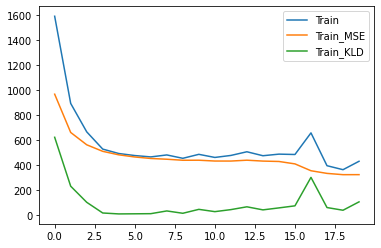

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(train_losses_MSE)
plt.plot(train_losses_KLD)
plt.legend(['Train', 'Train_MSE', 'Train_KLD'])
#plt.ylim([0,100])

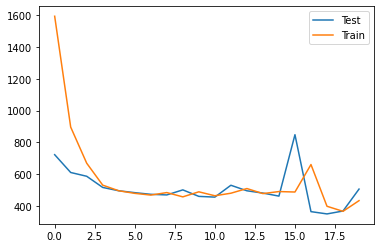

In [ ]:
import matplotlib.pyplot as plt
plt.plot(test_losses)
plt.plot(train_losses)
plt.legend(['Test', 'Train'])

### Draw random samples form latent space and generate new data

In [ ]:
with torch.no_grad():
    for batch_idx, data in enumerate(testloader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        break

In [ ]:
sigma = torch.exp(logvar/2)
# sample z from q
no_samples = 20
q = torch.distributions.Normal(mu.mean(axis=0), sigma.mean(axis=0))
z = q.rsample(sample_shape=torch.Size([no_samples]))

with torch.no_grad():
    pred = model.decode(z).cpu().numpy()

df = preprocessor.decodeOutput(pred)
df[0]

,amount,unit,ingredient
0,301.90237,,CILANTRO
1,174.86275,cup,smidge
2,98.57543,,MACHINE
3,176.3227,,20min
4,85.18308,,
5,104.26193,cup,
6,75.91534,,
7,65.62895,,
8,50.918816,,
9,59.068768,,
